# Introduction
This notebook contains a working example to show usage of the image perturbation and detector-based saliency map generation API.

This example will follow an application-like use-case where we define a functionally rigid process that transforms an input image into a number of saliency heat-maps based on our black-box detector's output, visualizing them over the input image.
We will show that it is easy to change which of our API implementations are used in the application without impacting the application's successful execution, first using a sliding-window perterbation algorithm and then using the RISE perturbation algorithm.

This will necessarilly include the use of a detector model to perform the role of the black-box detector that we will be determining the saliency for.
We will fill this role here with a PyTorch MSCOCO-pretrained FasterRCNN-ResNet50 network.

### Table of Contents
* [The test image](#The-test-image)
* [The "application"](#The-"application")
* [Black-box Detector](#Black-box-Detector)
* [XAI Components](#XAI-Components)
* [Calling the Application](#Calling-the-Application)

### Additional Python Requirements
The following additional python packages are required for this notebook besides the usual depedencies for `xaitk-saliency`:
- jupyter
- torch (tested with 1.9.0)
- torchvision  (tested with 0.10.0)

### Miscellaneous
Reference for implementation: Petsiuk, Vitali, et al. "Black-box explanation of object 
detectors via saliency maps." Proceedings of the IEEE/CVF Conference on Computer Vision 
and Pattern Recognition. 2021.

License for test image used may be found in 'COCO-LICENSE.txt'.

# The test image
We will test this application on the following image.
We know that this image contains the MS COCO classes of "dog" and "cat".

In [1]:
from skimage import io
import urllib.request
import matplotlib.pyplot as plt


# Test image to be explained
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', "catdog.jpg")
test_image_filename = 'catdog.jpg'
# ref_image = PIL.Image.open(test_image_filename)
ref_image = io.imread(test_image_filename)

plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(ref_image)

# The "application"
First we will set up our application as a function with defined inputs for
  * the image
  * black-box detector
  * image perturbation API implementation
  * saliency map generation API implementation

For the purposes of this tool, let's say that the input blackbox detector must take in one image and a list of class indices to output a dictionary of 'labels', 'scores' and 'boxes' per-detection (`Callable[[PIL.Image.Image, int], np.ndarray]`) for simplicity.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from typing import Callable, Optional, Sequence, Union
from xaitk_saliency import PerturbImage, GenerateDetectorProposalSaliency
from xaitk_saliency.utils.masking import occlude_image_batch
import matplotlib.patches as patches


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_detect: Callable[[PIL.Image.Image], np.ndarray],
    perturber: PerturbImage,
    sal_map_generator: GenerateDetectorProposalSaliency,
    fill: Optional[Union[int, Sequence[int]]] = None,
    vis_mask_examples: bool = True,
):
    # Load the image
    ref_image = io.imread(image_filepath)
    # Use the perterbation API implementation input to generate a bunch of images.
    # We will use the outputs here multiple times later so we will just aggregate
    # the output here.
    pert_masks = perturber(ref_image)
    print(f"Perterbation masks: {pert_masks.shape}")
    
    pert_imgs = occlude_image_batch(ref_image, pert_masks, fill)
    print(f"Perterbed images: {len(pert_imgs)}")

    # Visualize some example perturbed images before heading into blackbox detection
    if vis_mask_examples:
        n = 4
        print(f"Visualizing {n} random perturbed images...")
        rng = np.random.default_rng(seed=0)
        rng_idx_lst = sorted(rng.integers(0, len(pert_masks)-1, n))
        plt.figure(figsize=(n*4, 3))
        for i, rnd_i in enumerate(rng_idx_lst):
            plt.subplot(1, n, i+1)
            plt.title(f"pert_imgs[{rnd_i}]")
            plt.axis('off')
            plt.imshow(pert_imgs[rnd_i])

    # For the saliency heatmap generation API we need reference image detection as well as
    # the detections for each of the perturbed images.
    ref_preds = detector_blackbox(ref_image, sal_class_idxs)
    org_pred = ref_preds[:, 5]
    print(f"Ref preds: {ref_preds.shape}")
    pert_preds = np.asarray([
        detector_blackbox(pi, org_pred)
        for pi in pert_imgs
    ])
    print(f"Pert preds: {pert_preds.shape}")
    sal_maps = sal_map_generator.generate(ref_preds, pert_preds, pert_masks)
    print(f"Saliency maps: {sal_maps.shape}")

    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i + 1 } saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        ax = plt.gca()
        bbox = ref_preds[i, 0:4]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1,\
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        ax = plt.gca()
        bbox = ref_preds[i, 0:4]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], \
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')
        plt.show()
        plt.close()
    return sal_maps

# Black-box Detector
In this example we will use a basic PyTorch-based pretrained Faster-RCNN object detector with a ResNet50 backbone.
Since this model normally outputs a dictionary of all labels, scores and bounding boxes detected in the image, we will, for simplicity of example, constrain the output to the two classes that we happen to know are relevant for our test image.

In [3]:
from torchvision import transforms
import torchvision.models as models
import torch
import numpy as np
import os


# Imagenet class for which saliency maps need to be computed 
sal_classes = ['dog', 'cat']

# Grabbing the class labels associated with this model.
if not os.path.isfile('coco_classes.txt'):
    !wget https://raw.github.com/amikelive/coco-labels/master/coco-labels-paper.txt -O coco_classes.txt

f = open("coco_classes.txt", "r")
categories = [s.strip() for s in f.readlines()]
# Accounting for background class in detection
sal_class_idxs = [categories.index(lbl) + 1 for lbl in sal_classes]

CUDA_AVAILABLE = torch.cuda.is_available()
model_mean = [0.485, 0.456, 0.406]
detector_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True,\
                                                        num_classes=91, pretrained_backbone=True,
                                                         image_mean=model_mean)
model_input_size = (ref_image.shape[1], ref_image.shape[0])

class DetectorBlackBox():
    
    def __init__(self,
                model,
                model_mean,
                model_input_size):

        model = model.eval()
        if CUDA_AVAILABLE:
            model = model.cuda()
        self.model = model
        del model
        self.model_loader = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize(model_input_size), 
                            transforms.ToTensor(),
                        ])
        
    def __call__(self, image, org_class):
        image_tensor = self.model_loader(image).unsqueeze(0)
        if CUDA_AVAILABLE:
            image_tensor = image_tensor.cuda()
        dets = self.model(image_tensor)
        dets = dets[0]
        dets_cp = {}
        for _k, _v in dets.items():
            dets_cp[_k] = _v.cpu().detach().numpy()
        del dets
        dets = dets_cp
        filtered = np.empty((len(org_class), 7))        
        for c_ind, classlabel in enumerate(org_class):
            indi = np.where(dets['labels'] == classlabel)[0]
            if len(indi) != 0:
                filtered[c_ind, 0:4] = dets['boxes'][indi[0]] 
                filtered[c_ind, 5] = dets['labels'][indi[0]]                   
                filtered[c_ind, 6] = dets['scores'][indi[0]] 
            else:
                # Setting all values to one in case the original 
                # prediction was absent in the perturbed detections                
                filtered[c_ind, 0:4] = np.ones((dets['boxes'][0].shape)) 
                filtered[c_ind, 5] = np.ones((dets['labels'][0]).shape)              
                filtered[c_ind, 6] = np.ones((dets['scores'][0]).shape)
        return filtered

detector_blackbox = DetectorBlackBox(detector_model,  model_mean, model_input_size)

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

--2021-08-13 09:31:09--  https://raw.github.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.github.com (raw.github.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.github.com (raw.github.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt [following]
--2021-08-13 09:31:10--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco_classes.txt’

coco_classes.txt    100%[===================>]     702  --.-KB/s    in 0s      

2021-08-13 09:31:10 (19.0 MB/s) 

# XAI Components
Here we will setup our XAI components comprised of image perturbation and detector-based saliency map generation.

We will start with the sliding-window perturbation method and the DRISE-based saliency map generation method.

We additionally construct a second perturber, RISE, that we will use in a second invocation of the "application" to show that it still functions successfully due to API consistency, but with different results as per using a different algorithm.

In [4]:
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow
from xaitk_saliency.impls.perturb_image.rise import RISEGrid

from xaitk_saliency.impls.gen_detector_prop_sal.drise_scoring import DetectorRISE

# Constructing xaitk implementations for Occlusion-Based Detector Saliency generation with
# random masking and sliding window.
slid_window = SlidingWindow(window_size=(50, 50), stride=(30, 30))
rise_perturber = RISEGrid(200, 8, 0.5, seed=0, threads=4)
detect_alg = DetectorRISE()

# Calling the Application
Here we will show that can invoke the same "application" (function) with different `xaitk-saliency` API interface implementations while still successfully executing, visualizing the different results that are generated.

## RISE perturbation + DRISE

Perterbation masks: (200, 480, 640)
Perterbed images: 200
Ref preds: (2, 7)
Pert preds: (200, 2, 7)
Saliency maps: (2, 480, 640)
Class 1 saliency map range: [0.8552504546062573, 0.9227178168866259]


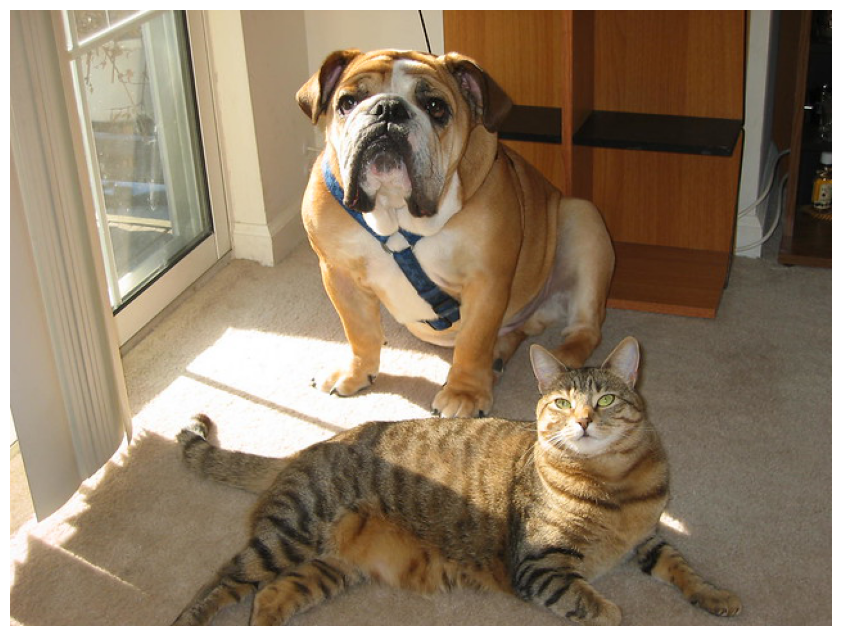

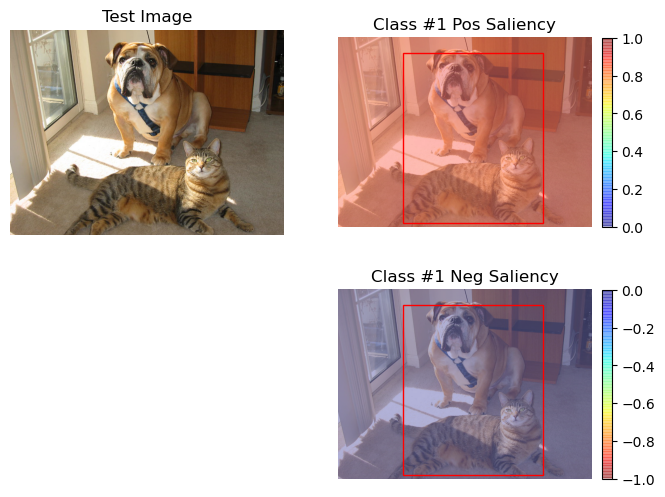

Class 2 saliency map range: [0.14086922154756262, 0.15374321020275272]


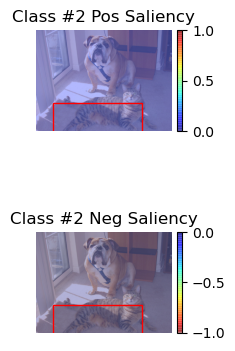

In [5]:
sal_maps = app(
    test_image_filename,
    detector_blackbox,
    rise_perturber,
    detect_alg,
    fill=blackbox_fill,
    vis_mask_examples=False,
)

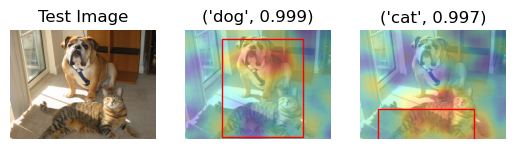

In [6]:
import matplotlib.patches as patches

org_det = detector_blackbox(ref_image, sal_class_idxs)

sub_plot_ind = len(sal_maps) + 1
plt.figure()
plt.subplot(1, sub_plot_ind, 1)
plt.imshow(ref_image)
plt.axis('off')
plt.title('Test Image')

for i, class_sal_map in enumerate(sal_maps):
    plt.subplot(1, sub_plot_ind, i+2)
    plt.imshow(ref_image, alpha=0.7)
    plt.imshow(
        class_sal_map,
        cmap='jet', alpha=0.3
    )
    bbox = np.round(org_det[i][:4])
    conf = round(org_det[i][6], 3)
#     Create a Rectangle patch
    ax = plt.gca()
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

#     Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(f"{sal_classes[i], conf}")
    plt.axis('off')
plt.show()

## Sliding window perturbation + DRISE

sal_maps = app(
    test_image_filename,
    detector_blackbox,
    slid_window,
    detect_alg,
    fill=blackbox_fill,
    vis_mask_examples=False,
)

sub_plot_ind = len(sal_maps) + 1
plt.figure()
plt.subplot(1, sub_plot_ind, 1)
plt.imshow(ref_image)
plt.axis('off')
plt.title('Test Image')

for i, class_sal_map in enumerate(sal_maps):
    plt.subplot(1, sub_plot_ind, i+2)
    plt.imshow(ref_image, alpha=0.7)
    plt.imshow(
        class_sal_map,
        cmap='jet', alpha=0.3
    )
    bbox = np.round(org_det[i][:4])
    conf = round(org_det[i][6], 3)
    # Create a Rectangle patch
    ax = plt.gca()
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(f"{sal_classes[i], conf}")
    plt.axis('off')
plt.show()